# Time Series Prediction


In [1]:
# @ Lukman copyright 
# MIT Licence

In [21]:
# for data frame analysis
import pandas as pd 

# for mathematical operations
import numpy as np 


# matplotlib library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Normalizing data
from sklearn.preprocessing import StandardScaler

# For statistical test
import scipy.stats as stats

# Split data set into training and test set
from sklearn.model_selection import train_test_split as tts

# SVN module
from sklearn import svm

# Kernel Functions used 
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel

# module for chi square test
from scipy.stats import chisquare


# For dictionary 
from collections import defaultdict

# for use of tensorflow
import tensorflow as tf
#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *
from tensorflow.keras import regularizers

# for scaling arrays
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler


# for random sampling of validation set
import random


import yaml
import os
from utility import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# enable eager executinon
tf.enable_eager_execution()

In [7]:
tf.__version__

'1.15.0'

# Data Preprocessing 

In [80]:
################################################################################
# load config file
try:
    with open("../config.yml", 'r') as ymlfile:
            cfg = yaml.safe_load(ymlfile)
except (IOError):
    print('config file is required. Put config file in current directory')
################################################################################

In [17]:
# current working directory
cwd = os.getcwd()
# set the base directory. base directo
BASE_DIR = os.path.join( os.path.dirname( cwd), '' )
# cleaned data dir
cleanedpath= BASE_DIR + cfg['cleanedconfig']['cleanedDataV1']['cleanedDir'] 
# clean data Name
cleandataName = cfg['cleanedconfig']['cleanedDataV1']['cleanedName']
# traina and validation data name
trainName= cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanTrain']
validateName  = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanValidate']
validation_split = cfg['cleanedconfig']['cleanedDataV1']['validationSplit']

In [18]:
# boolean for preprocessing datasets for tensorflow
tfreprocess = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfprocess']

In [28]:
if tfreprocess:
    
    _,_,data_types,col_names= utils.tfdatabuilder(cleanedpath,cleandataName,trainName, validateName,validation_split )
    
else:
    
    train = pd.read_csv(cleanedpath + trainName) 
    data_types,col_names = utils.tfpreprocess(train)

#### Work with downloaded csv to preserve data type
Load the csv file and parse the data types of the datatset together into the
tensorflow load pipeline

In [58]:
# load the data using the tensorflow Dataset API
# add the data types too
csvData = tf.data.experimental.CsvDataset(cleanedpath + trainName, data_types, header=True)

In [81]:
# check the data type :
#print(list(csvData.take(1)))

In [62]:
#col_names

In [63]:
# categorical features to use 
catfeatures = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['categoricalFeatureToUse']
catNames = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['CategoricalFeature']


#### Parse data 

In [64]:
# Parsing the data and
# merging the columns:
# ---- day and month as single column
# ---- merge the site id as a single feature vector vector
# ---- primary use as a single feature vector

# take the forst 4 col names that meter reading, square feet, air temp , dew temp,
# add it to a the new column names that would be formed after single column merging

#categorical feature selection
# here one can decide if to use site id or not . Site id is index 2 from catnames
if catfeatures == 3:
    col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],catNames[0],catNames[1],catNames[2] ]
else:
    col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],catNames[0],catNames[1]]

def _parse_csv_row(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:7])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[7:21]) # this index can be chage but ensure consistency 
    if catfeatures == 3:
        # site id as single feature
        site_id =  tf.convert_to_tensor(vals[21:31])
    
        # merge the features together, note meter reading is the fist column
        # so it is excluded -- meaning index starts from 1
        feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    else:
        feature_vals = vals[1:4] + (month_day,primary_use)
        
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    
    return features, targets_tensor

##### Batch the datatset

In [65]:

dataset = csvData.map(_parse_csv_row).batch(64)

In [66]:

#print(list(dataset.take(1)))

##### Feature Categorization

In [67]:
primary_use = tf.feature_column.numeric_column(catNames[1], shape=(14,))
site_id = tf.feature_column.numeric_column(catNames[2], shape=(10,))
month_day = tf.feature_column.numeric_column(catNames[0], shape=(3,))

In [68]:
normalizer = lambda x: tf.math.divide(tf.math.subtract(x, tf.reduce_mean(x)), tf.math.reduce_std(x)+1e-8)

In [69]:
numeric_columns = [tf.feature_column.numeric_column(feat,normalizer_fn=normalizer) for feat in col_names_[2:4]]

In [70]:
sqft = [tf.feature_column.numeric_column(col_names_[1])]

In [71]:
columns = sqft+numeric_columns + [month_day,primary_use,site_id]

In [72]:
feature_layer = tf.keras.layers.DenseFeatures(columns)

# Build Model

In [73]:
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import  NonNeg

def root_mean_squared_error(y_true, y_pred):
    '''
    
    this is the loss function specified in kaggle competition
    '''
        
    return K.sqrt(K.mean (K.square( (K.log(K.abs(y_pred)+1) - K.log(y_true+1))   )   )   )



def root_mean_squared_error2(y_true, y_pred):
    '''
    this is 1.- mean squared
    root mean squared is a value between 0 and 1 
    to reflect accuracy use 1-rms
    '''
        
    return  K.sqrt(K.mean( ( K.square ( y_pred - y_true    )   )   )) 

In [74]:
# model layer 
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(64,kernel_constraint=NonNeg()),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32,activation='relu',kernel_constraint=NonNeg()),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16,kernel_regularizer=regularizers.l2(1e-2),kernel_constraint=NonNeg()),
     tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8,activation='relu',kernel_constraint=NonNeg()),
     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='relu',kernel_constraint=NonNeg()),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Dense(1, activation='linear',kernel_constraint=NonNeg())
])


In [75]:
model.compile(optimizer = tf.train.AdagradOptimizer(1e-4),
             loss=root_mean_squared_error)

# error ranges value 1e-2 to 1e-4 for good performance

# Optimizer to use '''''' AdagradOptimizer and root_mean_squared_error2 ranges 1
# Adam --- not good
# Adam
#Rmsprop


In [76]:
import os
checkpoint_path = cfg['savedModel']['myname']['Dir2'] + cfg['savedModel']['myname']['modelName2']
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_dir


'savedModels/tfAPINormalized'

In [77]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [78]:
train_epochs = 5# increase this to train data better
restore = False
# for loop trains incrementally
# this issue https://github.com/keras-team/keras/issues/4446
for i in range(train_epochs):  
    if restore:
        model.load_weights(checkpoint_path)
    model.fit(dataset,epochs=10,steps_per_epoch=40,callbacks=[cp_callback])
    restore = True
    


Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
37/40 [==========================>...] - ETA: 0s - loss: 8.7383
Epoch 00001: saving model to savedModels/tfAPINormalized/tfAPINormalized.ckpt
40/40 [==============================] - 3s 79ms/step - loss: 8.7554
Epoch 2/10
37/40 [==========================>...] - ETA: 0s - loss: 8.7550
Epoch 00002: saving model to savedModels/tfAPINormalized/tfAPINormalized.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 8.7436
Epoch 3/10
37/40 [==========================>...] - ETA: 0s - loss: 8.7748
Epoch 00003: saving model to savedModels/tfAPINormalized/tfAPINormalized.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 8.7678
Epoch 4/10
37/40 [==========================>...] - ETA: 0s - loss: 8.9154
Epoch 00004: saving model to savedModels/tfAPINormalized/tfAPINormalized.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 8.9024
Epoch 5/10
37/40 [===

Epoch 7/10
38/40 [===========================>..] - ETA: 0s - loss: 8.7105
Epoch 00007: saving model to savedModels/tfAPINormalized/tfAPINormalized.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 8.7157
Epoch 8/10
36/40 [==========================>...] - ETA: 0s - loss: 8.4913
Epoch 00008: saving model to savedModels/tfAPINormalized/tfAPINormalized.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 8.4940
Epoch 9/10
36/40 [==========================>...] - ETA: 0s - loss: 8.3874
Epoch 00009: saving model to savedModels/tfAPINormalized/tfAPINormalized.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 8.4132
Epoch 10/10
37/40 [==========================>...] - ETA: 0s - loss: 8.6173
Epoch 00010: saving model to savedModels/tfAPINormalized/tfAPINormalized.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 8.6266
Epoch 1/10
35/40 [=========================>....] - ETA: 0s - loss: 8.6646
Epoch 00001: saving model to savedModels

## Testing

In [79]:
# testing not yet activated

In [116]:
def _parse_csv_row2(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:7])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[7:21])
    # site id as single feature
    site_id =  tf.convert_to_tensor(vals[21:30])
    
    # merge the features together, note meter reading is the fist column
    # so it is excluded -- meaning index starts from 1
    feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    
    return features

In [117]:
testdata = tf.data.experimental.CsvDataset('meter1Test.csv', data_types, header=False)

In [118]:
test = testdata.map(_parse_csv_row2).batch(1)

In [119]:
# predicitons 
predictions = model.predict(test)

In [120]:
# get true values
true_values=pd.read_csv('meter1Test.csv',header=None)[0].values

Text(0.5, 0, 'Iterations')

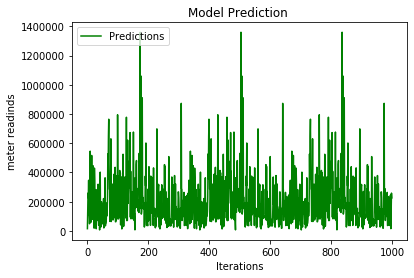

In [121]:
plt.plot(predictions,"-g" ,label='Predictions')
#plt.plot(true_values, "-r",label='True Values')
plt.legend(loc="upper left")
plt.title('Model Prediction ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

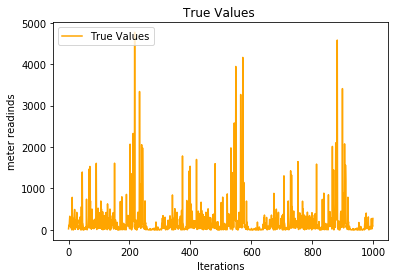

In [199]:
#plt.plot(predictions,"-g" ,label='Predictions')
plt.plot(true_values, "-r",label='True Values',color='orange')
plt.legend(loc="upper left")
plt.title('True Values ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

### Per Building plot

In [122]:
from utility import utils
%load_ext autoreload
%autoreload 2

In [124]:
test_predicted = pd.DataFrame(list(zip(test_building_id,test_timestamp,list(predictions))),columns= ['building_id','timestamp', 'meter_reading' ,] )

In [125]:
true_readings = pd.DataFrame(list(zip(test_building_id,test_timestamp,list(true_values))),columns= ['building_id','timestamp', 'meter_reading' ,] )

/home/cat/anaconda3/envs/cat/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


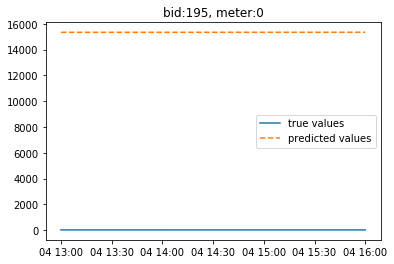

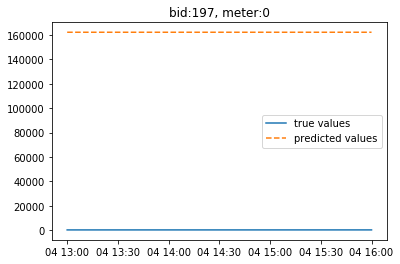

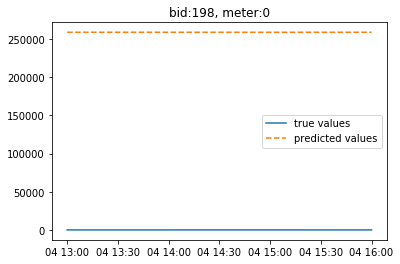

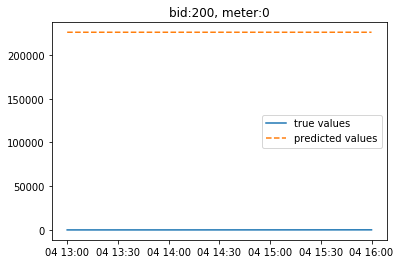

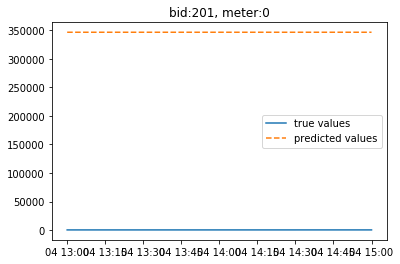

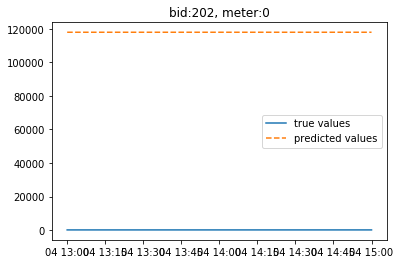

In [126]:
utils.plot_meter(true_readings,test_predicted,n_plots=5)

Text(0.5, 15.0, 'Iterations')

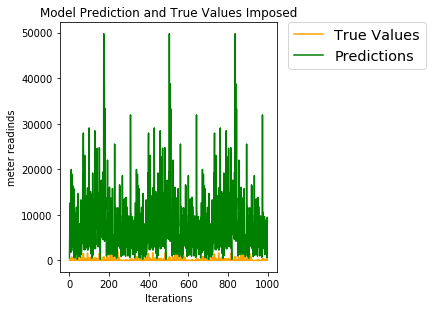

In [76]:
plt.plot(true_values, "-r",label='True Values',color='orange')
plt.plot(predictions,"-g" ,label='Predictions',color='green')

plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='x-large')
plt.tight_layout()

plt.title('Model Prediction and True Values Imposed')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')